# Obtención de estadísticas

## 1 Información de uso de memoria RAM y CPU

In [ ]:
import psutil
import time
import csv
from datetime import datetime, timedelta

# PID del proceso que deseas monitorear
PID_OBJETIVO = 28752  # PID proceso generado por la ejecución del DT (Encontrar manualmente mediante administrador de tareas)

# Intervalo de muestreo en segundos
INTERVALO = 1.0

# Duración total del monitoreo en minutos
DURACION_MINUTOS = 10

# Nombre del archivo de salida
nombre_csv = f"uso_cpu_ram_{PID_OBJETIVO}.csv"

# Obtener el proceso
try:
    proceso = psutil.Process(PID_OBJETIVO)
except psutil.NoSuchProcess:
    print(" No existe un proceso con ese PID.")
    exit()

# Tiempo de fin
tiempo_inicio = datetime.now()
tiempo_fin = tiempo_inicio + timedelta(minutes=DURACION_MINUTOS)

# Crear archivo CSV y escribir encabezado
with open(nombre_csv, mode='w', newline='') as archivo:
    escritor = csv.writer(archivo)
    escritor.writerow(['Timestamp', 'CPU (%)', 'RAM (MB)'])

    print(f" Monitoreando PID {PID_OBJETIVO} durante {DURACION_MINUTOS} minutos...")
    try:
        while datetime.now() < tiempo_fin:
            cpu = proceso.cpu_percent(interval=None)  # % de CPU desde la última llamada
            ram = proceso.memory_info().rss / (1024 * 1024)  # RAM en MB
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            escritor.writerow([timestamp, cpu, ram])
            print(f"{timestamp} | CPU: {cpu:.2f}% | RAM: {ram:.2f} MB")
            time.sleep(INTERVALO)
    except KeyboardInterrupt:
        print("\n Monitoreo detenido manualmente.")
    finally:
        print(" Monitoreo finalizado. Datos guardados en:", nombre_csv)

## 2 Recopilación de latencia al puslar una tecla

### Modo servidor del ejecutable

In [ ]:
# Si se desea probar este scipt, se recomienda tener en primer plano la ventana ejecutable del DT
# de lo contrario, la pulsación podría no detectarse
from opcua import Client
from datetime import datetime
import csv
import time
import os
import keyboard  # pip install keyboard
from time import sleep

# === CONFIGURACIÓN ===
URL = "opc.tcp://127.0.0.1:4840"

# IDs de nodos OPC UA
NODO_1_ID = "ns=1;i=NivelTanque1"      # altura tanque 1
NODO_2_ID = "ns=1;i=NivelTanque2"      # altura tanque 2
NODO_3_ID = "ns=1;i=CaudalEntrada"     # Qin
NODO_4_ID = "ns=1;i=CaudalSalida"      # Qout
NODO_5_ID = "ns=1;i=CaudalIntermedio"  # Qint

TIEMPO_EJECUCION = 720                 # Segundos totales
CSV_FILE = "lecturas_simuladas6.csv"   # Nombre del archivo a generar
APPEND_MODE = False

INTERVALO_INTERNO = 1 / 3              # Polling cada 0.333 segundos
LECTURAS_POR_SEGUNDO = 3

# Estados iniciales de los controles simulados
ctrl_bomba = 0
ctrl_svalve = 0
ctrl_bvalve = 0

# División de fases
fase_duracion = TIEMPO_EJECUCION / 5
fase_2_inicio = fase_duracion
fase_2_fin = 4 * fase_duracion
fase_4_inicio = TIEMPO_EJECUCION - fase_duracion

# Timers de teclas
ultimo_4 = -99
ultimo_5 = -99
ultimo_6 = -99

# Conectar cliente
client = Client(URL)
sleep(6.0) # Ventana de tiempo para ubicarse en la ventana del ejecutable

try:
    with client:
        print("Conectado al servidor OPC UA")

        # Obtener nodos
        nodo1 = client.get_node(NODO_1_ID)
        nodo2 = client.get_node(NODO_2_ID)
        nodo3 = client.get_node(NODO_3_ID)
        nodo4 = client.get_node(NODO_4_ID)
        nodo5 = client.get_node(NODO_5_ID)

        # Preparar CSV
        mode = 'a' if APPEND_MODE and os.path.exists(CSV_FILE) else 'w'
        with open(CSV_FILE, mode=mode, newline='') as archivo:
            writer = csv.writer(archivo)
            if mode == 'w' or not os.path.exists(CSV_FILE):
                writer.writerow([
                    "TimestampLocal", "Nivel1", "Nivel2",
                    "CtrlBomba", "CtrlSValve", "CtrlBValve",
                    "Qin", "Qout", "Qint"
                ])

            print("Iniciando simulación...")

            start = time.time()
            while (time.time() - start) < TIEMPO_EJECUCION:
                elapsed = time.time() - start
                seg = int(elapsed)

                # === FASES DE SIMULACIÓN ===
                if fase_2_inicio <= elapsed < fase_2_fin:
                    if seg - ultimo_4 >= 15:
                        ctrl_bomba = 1 - ctrl_bomba
                        keyboard.press_and_release('4')
                        ultimo_4 = seg
                        print("Tecla 4 simulada")

                    if seg - ultimo_5 >= 5:
                        ctrl_svalve = 1 - ctrl_svalve
                        keyboard.press_and_release('5')
                        ultimo_5 = seg
                        print("Tecla 5 simulada")

                    if seg - ultimo_6 >= 10:
                        ctrl_bvalve = 1 - ctrl_bvalve
                        keyboard.press_and_release('6')
                        ultimo_6 = seg
                        print("Tecla 6 simulada")

                elif elapsed >= fase_4_inicio:
                    # Última fase: poner todo en 0 una vez
                    if ctrl_bomba != 0 or ctrl_svalve != 0 or ctrl_bvalve != 0:
                        ctrl_bomba = ctrl_svalve = ctrl_bvalve = 0
                        if ctrl_bomba != 0:
                            keyboard.press_and_release('4')
                        if ctrl_bvalve != 0:
                            keyboard.press_and_release('6')
                        if ctrl_svalve != 0:
                            keyboard.press_and_release('5')
                        print("Reset final de controles: B=0, S=0, V=0")

                # Leer caudales
                try:
                    val_qin = float(nodo3.get_value())
                    val_qout = float(nodo4.get_value())
                    val_qint = float(nodo5.get_value())
                except Exception as e:
                    print(f"Error al leer caudales: {e}")
                    val_qin = val_qout = val_qint = 0.0

                # Promediar niveles
                vals_1 = []
                vals_2 = []
                for _ in range(LECTURAS_POR_SEGUNDO):
                    try:
                        vals_1.append(float(nodo1.get_value()))
                        vals_2.append(float(nodo2.get_value()))
                    except Exception as e:
                        print(f"Error al leer niveles: {e}")
                        vals_1.append(0.0)
                        vals_2.append(0.0)
                    time.sleep(INTERVALO_INTERNO)

                promedio_1 = sum(vals_1) / len(vals_1)
                promedio_2 = sum(vals_2) / len(vals_2)

                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]
                writer.writerow([
                    timestamp, promedio_1, promedio_2,
                    ctrl_bomba, ctrl_svalve, ctrl_bvalve,
                    val_qin, val_qout, val_qint
                ])

                print(f"[{timestamp}] Niveles: {promedio_1:.2f}, {promedio_2:.2f} | B: {ctrl_bomba} S: {ctrl_svalve} V: {ctrl_bvalve}")

        print("Finalizado y datos guardados.")

except Exception as e:
    print("Error:", e)

finally:
    print("Desconectado del servidor OPC UA.")

### Conexión con la planta física

In [ ]:
# Si se desea probar este scipt, se recomienda tener en primer plano la ventana ejecutable del DT
# de lo contrario, la pulsación podría no detectarse
from opcua import Client
from datetime import datetime
import csv
import time
import os
import keyboard  # pip install keyboard
from time import sleep

# === CONFIGURACIÓN ===
URL = "opc.tcp://10.21.162.10:4840"

# IDs de nodos OPC UA
NODO_1_ID = "ns=1;i=1005"  # altura tanque 1
NODO_2_ID = "ns=1;i=1006"  # altura tanque 2
NODO_3_ID = "ns=1;i=1007"  # Qin
NODO_4_ID = "ns=1;i=1008"  # Qout
NODO_5_ID = "ns=1;i=1009"  # Qint

TIEMPO_EJECUCION = 720                  # Segundos totales
CSV_FILE = "lecturas_simuladas6.csv"  # Nombre del archivo a generar
APPEND_MODE = False

INTERVALO_INTERNO = 1 / 3              # Polling cada 0.333 segundos
LECTURAS_POR_SEGUNDO = 3

# Estados iniciales de los controles simulados
ctrl_bomba = 0
ctrl_svalve = 0
ctrl_bvalve = 0

# División de fases
fase_duracion = TIEMPO_EJECUCION / 5
fase_2_inicio = fase_duracion
fase_2_fin = 4 * fase_duracion
fase_4_inicio = TIEMPO_EJECUCION - fase_duracion

# Timers de teclas
ultimo_4 = -99
ultimo_5 = -99
ultimo_6 = -99

# Conectar cliente
client = Client(URL)
sleep(6.0) # Ventana de tiempo para ubicarse en la ventana del ejecutable

try:
    with client:
        print("Conectado al servidor OPC UA")

        # Obtener nodos
        nodo1 = client.get_node(NODO_1_ID)
        nodo2 = client.get_node(NODO_2_ID)
        nodo3 = client.get_node(NODO_3_ID)
        nodo4 = client.get_node(NODO_4_ID)
        nodo5 = client.get_node(NODO_5_ID)

        # Preparar CSV
        mode = 'a' if APPEND_MODE and os.path.exists(CSV_FILE) else 'w'
        with open(CSV_FILE, mode=mode, newline='') as archivo:
            writer = csv.writer(archivo)
            if mode == 'w' or not os.path.exists(CSV_FILE):
                writer.writerow([
                    "TimestampLocal", "Nivel1", "Nivel2",
                    "CtrlBomba", "CtrlSValve", "CtrlBValve",
                    "Qin", "Qout", "Qint"
                ])

            print("Iniciando simulación...")

            start = time.time()
            while (time.time() - start) < TIEMPO_EJECUCION:
                elapsed = time.time() - start
                seg = int(elapsed)

                # === FASES DE SIMULACIÓN ===
                if fase_2_inicio <= elapsed < fase_2_fin:
                    if seg - ultimo_4 >= 15:
                        ctrl_bomba = 1 - ctrl_bomba
                        keyboard.press_and_release('4')
                        ultimo_4 = seg
                        print("Tecla 4 simulada")

                    if seg - ultimo_5 >= 5:
                        ctrl_svalve = 1 - ctrl_svalve
                        keyboard.press_and_release('5')
                        ultimo_5 = seg
                        print("Tecla 5 simulada")

                    if seg - ultimo_6 >= 10:
                        ctrl_bvalve = 1 - ctrl_bvalve
                        keyboard.press_and_release('6')
                        ultimo_6 = seg
                        print("Tecla 6 simulada")

                elif elapsed >= fase_4_inicio:
                    # Última fase: poner todo en 0 una vez
                    if ctrl_bomba != 0 or ctrl_svalve != 0 or ctrl_bvalve != 0:
                        ctrl_bomba = ctrl_svalve = ctrl_bvalve = 0
                        if ctrl_bomba != 0:
                            keyboard.press_and_release('4')
                        if ctrl_bvalve != 0:
                            keyboard.press_and_release('6')
                        if ctrl_svalve != 0:
                            keyboard.press_and_release('5')
                        print("Reset final de controles: B=0, S=0, V=0")

                # Leer caudales
                try:
                    val_qin = float(nodo3.get_value())
                    val_qout = float(nodo4.get_value())
                    val_qint = float(nodo5.get_value())
                except Exception as e:
                    print(f"Error al leer caudales: {e}")
                    val_qin = val_qout = val_qint = 0.0

                # Promediar niveles
                vals_1 = []
                vals_2 = []
                for _ in range(LECTURAS_POR_SEGUNDO):
                    try:
                        vals_1.append(float(nodo1.get_value()))
                        vals_2.append(float(nodo2.get_value()))
                    except Exception as e:
                        print(f"Error al leer niveles: {e}")
                        vals_1.append(0.0)
                        vals_2.append(0.0)
                    time.sleep(INTERVALO_INTERNO)

                promedio_1 = sum(vals_1) / len(vals_1)
                promedio_2 = sum(vals_2) / len(vals_2)

                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]
                writer.writerow([
                    timestamp, promedio_1, promedio_2,
                    ctrl_bomba, ctrl_svalve, ctrl_bvalve,
                    val_qin, val_qout, val_qint
                ])

                print(f"[{timestamp}] Niveles: {promedio_1:.2f}, {promedio_2:.2f} | B: {ctrl_bomba} S: {ctrl_svalve} V: {ctrl_bvalve}")

        print("Finalizado y datos guardados.")

except Exception as e:
    print("Error:", e)

finally:
    print("Desconectado del servidor OPC UA.")

## 3 Gráficas de los datos recopilados

### Uso de RAM a través del tiempo de ejecución

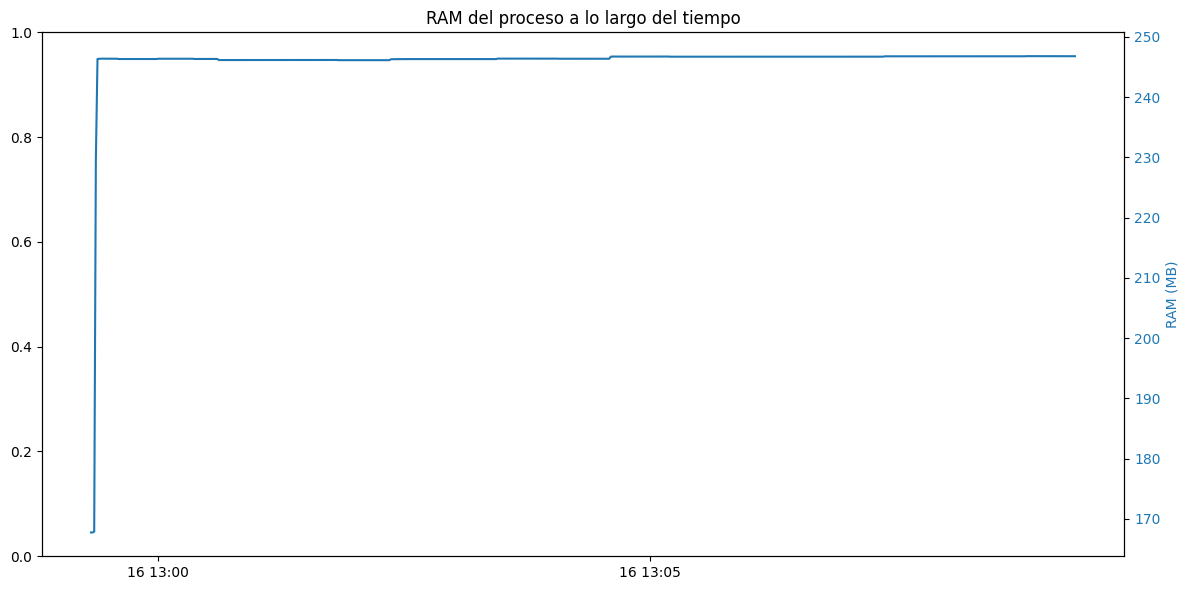

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta del archivo CSV generado
csv_path = "uso_cpu_ram_28752.csv"  # Cambiar PID_OBJETIVO por el PID en cuestión

# Leer CSV
df = pd.read_csv(csv_path)

# Convertir la columna de tiempo a tipo datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(12, 6))


# Crear segundo eje Y para la RAM
ax2 = ax1.twinx()
ax2.set_ylabel('RAM (MB)', color='tab:blue')
ax2.plot(df['Timestamp'], df['RAM (MB)'], color='tab:blue', label='RAM (MB)')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Título y formato
plt.title("RAM del proceso a lo largo del tiempo")
fig.tight_layout()

# Mostrar
plt.show()


### BOXPLOT sobre el uso de memoria RAM y CPU

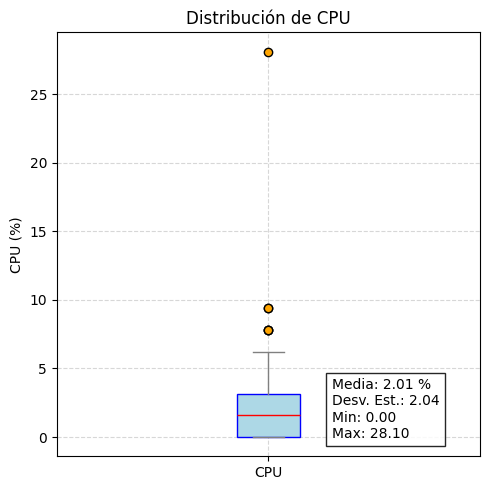

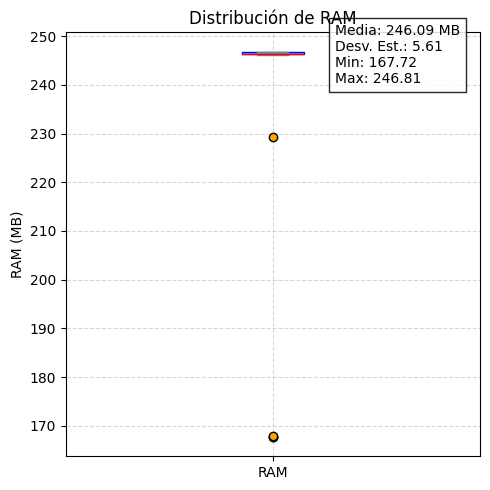

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Cargar datos
df = pd.read_csv("uso_cpu_ram_28752.csv")
cpu = df["CPU (%)"]
ram = df["RAM (MB)"]

# Función para generar cada boxplot
def graficar_boxplot(datos, etiqueta, color, unidad):
    media = datos.mean()
    std = datos.std()
    minimo = datos.min()
    maximo = datos.max()

    plt.figure(figsize=(5, 5))
    plt.boxplot(datos, patch_artist=True,
                boxprops=dict(facecolor=color, color="blue"),
                medianprops=dict(color="red"),
                whiskerprops=dict(color="gray"),
                capprops=dict(color="gray"),
                flierprops=dict(markerfacecolor="orange", marker='o', markersize=6, linestyle='none'))

    plt.title(f"Distribución de {etiqueta}")
    plt.ylabel(f"{etiqueta} ({unidad})")
    plt.xticks([1], [etiqueta])
    plt.grid(True, linestyle='--', alpha=0.5)

    texto = (
        f"Media: {media:.2f} {unidad}\n"
        f"Desv. Est.: {std:.2f}\n"
        f"Min: {minimo:.2f}\n"
        f"Max: {maximo:.2f}"
    )

    plt.text(1.15, media, texto, ha='left', va='center', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.85))

    plt.tight_layout()
    plt.show()

# Graficar por separado
graficar_boxplot(cpu, "CPU", "lightblue", "%")
graficar_boxplot(ram, "RAM", "lightgreen", "MB")


### BOXPLOT latencias

#### Envío de la señal al servidor físico a través de la aplicación

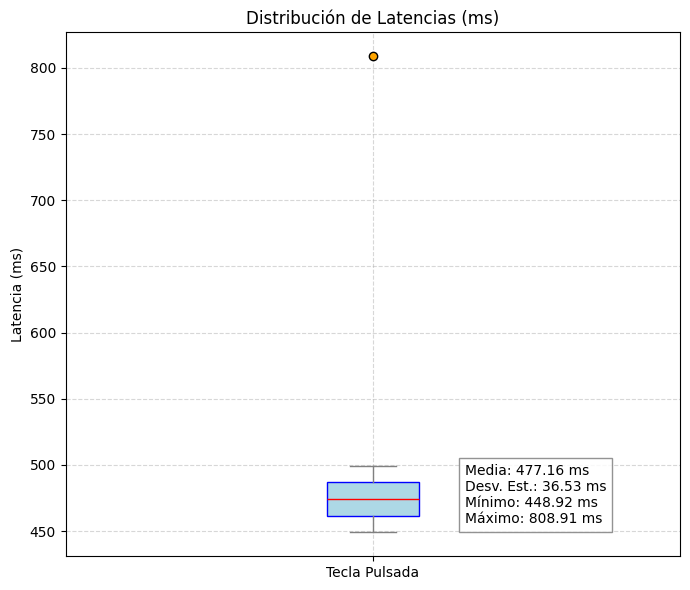

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Cargar archivo CSV
archivo = "latencias_tecla_4-serverN2.csv"
df = pd.read_csv(archivo)
latencias = df["Latencia (ms)"]

# Calcular estadísticas
media = latencias.mean()
std = latencias.std()
minimo = latencias.min()
maximo = latencias.max()

# Crear boxplot
plt.figure(figsize=(7, 6))
plt.boxplot(latencias, vert=True, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="red"),
            whiskerprops=dict(color="gray"),
            capprops=dict(color="gray"),
            flierprops=dict(markerfacecolor="orange", marker='o', markersize=6, linestyle='none'))

plt.title("Distribución de Latencias (ms)")
plt.ylabel("Latencia (ms)")
plt.xticks([1], ["Tecla Pulsada"])
plt.grid(True, linestyle='--', alpha=0.5)

# Agregar texto estadístico al lado derecho
texto = (
    f"Media: {media:.2f} ms\n"
    f"Desv. Est.: {std:.2f} ms\n"
    f"Mínimo: {minimo:.2f} ms\n"
    f"Máximo: {maximo:.2f} ms"
)

plt.text(1.15, media, texto, ha='left', va='center', fontsize=10,
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.85))

plt.tight_layout()
plt.show()


#### Latencia del modo servidor

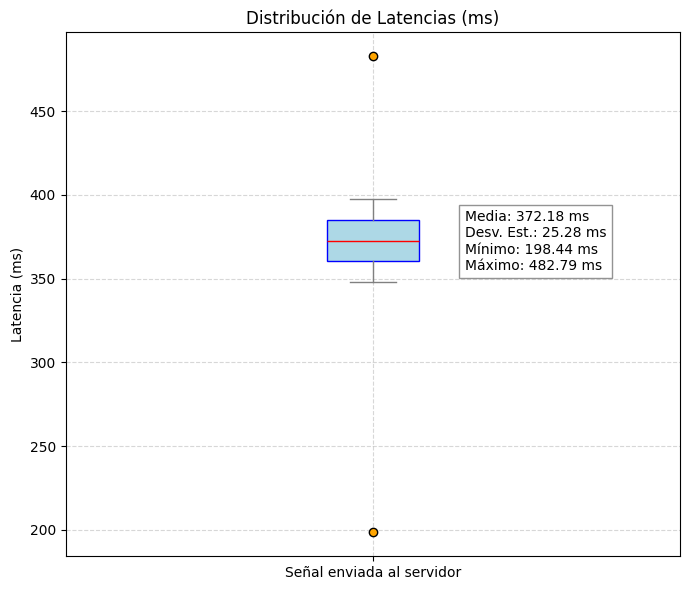

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Cargar archivo CSV
archivo = "latencias-server-cltext2.csv"
df = pd.read_csv(archivo)
latencias = df["Latencia (ms)"]

# Calcular estadísticas
media = latencias.mean()
std = latencias.std()
minimo = latencias.min()
maximo = latencias.max()

# Crear boxplot
plt.figure(figsize=(7, 6))
plt.boxplot(latencias, vert=True, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="red"),
            whiskerprops=dict(color="gray"),
            capprops=dict(color="gray"),
            flierprops=dict(markerfacecolor="orange", marker='o', markersize=6, linestyle='none'))

plt.title("Distribución de Latencias (ms)")
plt.ylabel("Latencia (ms)")
plt.xticks([1], ["Señal enviada al servidor"])
plt.grid(True, linestyle='--', alpha=0.5)

# Agregar texto estadístico al lado derecho
texto = (
    f"Media: {media:.2f} ms\n"
    f"Desv. Est.: {std:.2f} ms\n"
    f"Mínimo: {minimo:.2f} ms\n"
    f"Máximo: {maximo:.2f} ms"
)

plt.text(1.15, media, texto, ha='left', va='center', fontsize=10,
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.85))

plt.tight_layout()
plt.show()